In [1]:
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.Pipelines.skypy_pipeline import SkyPyPipeline
from astropy.modeling.models import Linear1D, Exponential1D
import numpy as np
import corner
from skypy.galaxies import schechter_lf
from astropy.table import vstack, Table

## Define a cosmology and sky area

In [2]:
# define a cosmology
cosmology = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
sky_area = Quantity(value=1, unit="deg2")


## Plot Schechter functions

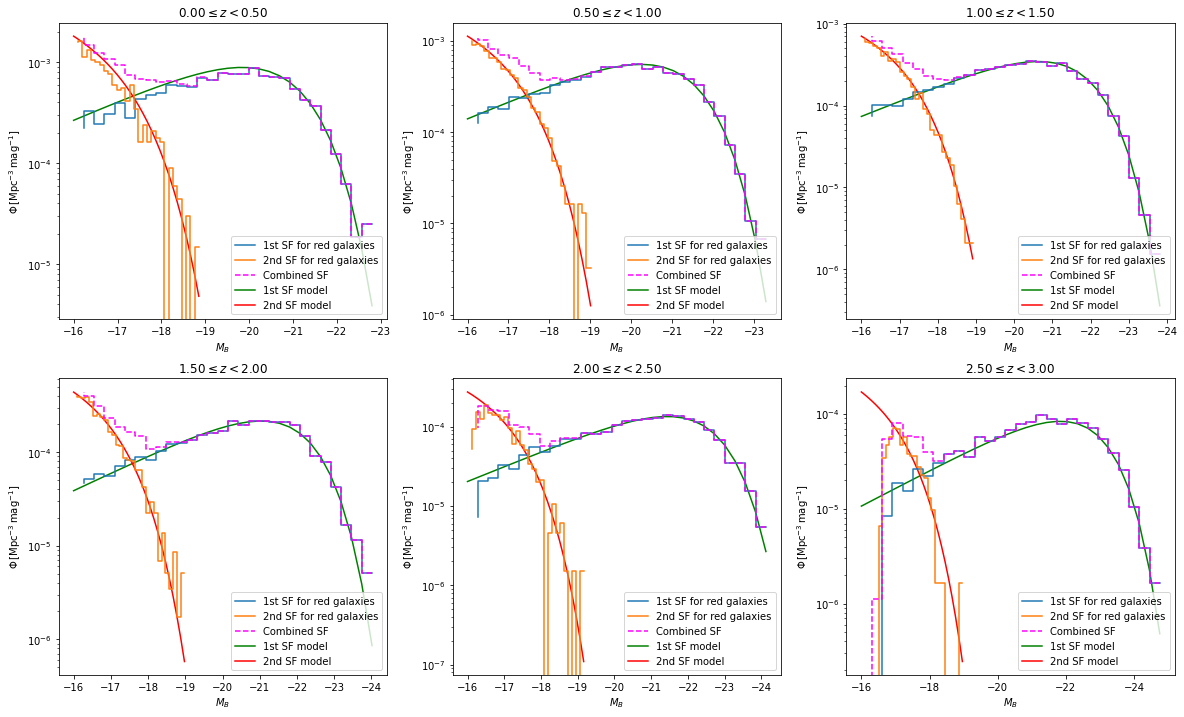

In [3]:
z_range = np.linspace(0.0, 3.01, 100)
## These are the parameters used in the lsst-like_new.yml file for 1st schechter 
# function for red galaxies.
m_star = Linear1D(-0.80, -20.46)
phi_star = Exponential1D(0.00278612, -1.05925)
alpha, mag_lim = -0.53, 30
redshift, magnitude = schechter_lf(z_range, m_star, phi_star, alpha,
                                   mag_lim, sky_area, cosmology, noise=True)

# 2nd schechter function
m_star2=-17
phi_star2 = Exponential1D(0.00278612, -1.05925)
alpha2, mag_lim2=-1.31, 30
redshift2, magnitude2 = schechter_lf(z_range, m_star2, phi_star2, alpha2,
                                   mag_lim2, sky_area, cosmology, noise=True)

#combined schechterfunction
redshift3=np.concatenate((redshift, redshift2))
magnitude3=np.concatenate((magnitude, magnitude2))


fig, ((ax1, ax2, ax3), 
      (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
bins = np.linspace(-24.84408295574346, -14, 40)
bins2 = np.linspace(-19.1724664526037, -14, 30)
z_slices = ((0., 0.5), (0.5, 1), (1, 1.5), (1.5, 2), (2, 2.5),
         (2.5, 3))

for ax, (z_min, z_max) in zip([ax1, ax2, ax3, ax4, ax5, ax6], z_slices):

    # Redshift grid
    z = np.linspace(z_min, z_max, 100)

    # SkyPy simulated galaxies
    z_mask = np.logical_and(redshift >= z_min, redshift < z_max)
    magnitude_bin=magnitude[z_mask]
    bins=np.linspace(min(magnitude_bin), -16, 30)
    dV_dz = (cosmology.differential_comoving_volume(z) * sky_area).to_value('Mpc3')
    dV = np.trapz(dV_dz, z)
    dM = (np.max(bins)-np.min(bins)) / (np.size(bins)-1)
    phi_first_red = np.histogram(magnitude[z_mask], bins=bins)[0] / dV / dM

    z_mask2 = np.logical_and(redshift2 >= z_min, redshift2 < z_max)
    magnitude_bin2=magnitude2[z_mask2]
    bins2=np.linspace(min(magnitude_bin2),-16, 30)
    dV_dz2 = (cosmology.differential_comoving_volume(z) * sky_area).to_value('Mpc3')
    dV2 = np.trapz(dV_dz2, z)
    dM2 = (np.max(bins2)-np.min(bins2)) / (np.size(bins2)-1)
    phi_second_red = np.histogram(magnitude2[z_mask2], bins=bins2)[0] / dV2 / dM2

    z_mask3 = np.logical_and(redshift3 >= z_min, redshift3 < z_max)
    dV_dz3 = (cosmology.differential_comoving_volume(z) * sky_area).to_value('Mpc3')
    dV3 = np.trapz(dV_dz3, z)
    dM3 = (np.max(bins)-np.min(bins)) / (np.size(bins)-1)
    phi_combined_red = np.histogram(magnitude3[z_mask3], bins=bins)[0] / dV3 / dM3

    # Median-redshift Schechter function
    L = 10 ** (0.4 * (m_star(z) - bins[:, np.newaxis]))
    phi_model_z = 0.4 * np.log(10) * phi_star(z) * L ** (alpha+1) * np.exp(-L)
    phi_model = np.median(phi_model_z, axis=1)

    L2 = 10 ** (0.4 * (m_star2 - bins2[:, np.newaxis]))
    phi_model_z2 = 0.4 * np.log(10) * phi_star(z) * L2 ** (alpha2+1) * np.exp(-L2)
    phi_model2 = np.median(phi_model_z2, axis=1)

    # Plotting
    ax.step(bins[:-1], phi_first_red, where='post', label='1st SF for red galaxies', zorder=3)
    ax.step(bins2[:-1], phi_second_red, where='post', label='2nd SF for red galaxies', zorder=3)
    ax.step(bins[:-1], phi_combined_red, where='post',ls="--", label='Combined SF', color="magenta", zorder=3)
    ax.plot(bins, phi_model, label='1st SF model', color='g')
    ax.plot(bins2, phi_model2, label='2nd SF model', color='red')
    ax.set_title(r'${:.2f} \leq z < {:.2f}$'.format(z_min, z_max))
    ax.set_xlabel(r'$M_B$')
    ax.set_ylabel(r'$\Phi \, [\mathrm{Mpc}^{-3} \, \mathrm{mag}^{-1}]$')
    ax.set_yscale('log')
    #ax.set_xlim([-14, -24])
    #ax.set_ylim([min(magnitude_bin), None])
    ax.legend(loc="lower right")
    ax.invert_xaxis()
plt.show()


## Get galaxy distribution from SkyPyPipeline

In [4]:
## For the red galaxies, this configuration uses combined Schechter 
# function (magenta curve in above plot).
pipeline_double=SkyPyPipeline(skypy_config="/Users/narayankhadka/Desktop/strong_lensing/lsst-like_new.yml", sky_area=None, filters=None,
 cosmo=cosmology)
## For the red galaxies, this configuration uses single Schechter 
# function (blue curve in above plot).
pipeline_single=SkyPyPipeline(skypy_config="/Users/narayankhadka/Desktop/strong_lensing/lsst-like.yml", sky_area=None, filters=None,
 cosmo=cosmology)

In [6]:
## Let's draw red galaxies from these two different Schechter function.
red_galaxies_double = pipeline_double.red_galaxies
red_galaxies_single = pipeline_single.red_galaxies

In [7]:
from astropy.table import vstack, Table

In [8]:
# These are all galaxies from from two cases.
single_total=vstack([pipeline_single.red_galaxies, 
pipeline_single.blue_galaxies])
double_total=vstack([pipeline_double.red_galaxies, 
pipeline_double.blue_galaxies])
"""single_total = np.concatenate((pipeline_single.red_galaxies["z"], 
pipeline_single.blue_galaxies["z"]))
double_total = np.concatenate((pipeline_double.red_galaxies["z"], pipeline_double.blue_galaxies["z"]))"""

'single_total = np.concatenate((pipeline_single.red_galaxies["z"], \npipeline_single.blue_galaxies["z"]))\ndouble_total = np.concatenate((pipeline_double.red_galaxies["z"], pipeline_double.blue_galaxies["z"]))'

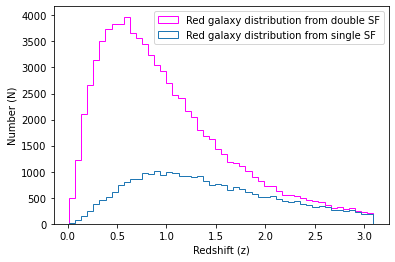

In [9]:
## Plot red galaxy distributions from single Schechter function and double Schcheter 
# functions.
plt.hist(red_galaxies_double["z"], bins=50, histtype="step",
            label="Red galaxy distribution from double SF", color="magenta")
plt.hist(red_galaxies_single["z"], bins=50, histtype="step",
            label="Red galaxy distribution from single SF")
plt.xlabel("Redshift (z)")
plt.ylabel("Number (N)")
plt.legend()

In [10]:
import pickle
with open("/Users/narayankhadka/downloads/dc2_galaxy2_catalog_1deg2.txt", 'rb') as file:
    # Use pickle.load() to load the data from the file
    dc2_galaxies = pickle.load(file)

with open("/Users/narayankhadka/downloads/dc2_galaxy1_catalog_1deg2.txt", 'rb') as file:
    # Use pickle.load() to load the data from the file
    dc2_galaxies2 = pickle.load(file)

with open("/Users/narayankhadka/downloads/diffsky_galaxy_catalog_1deg2.txt", 'rb') as file:
    # Use pickle.load() to load the data from the file
    diffsky_galaxies = pickle.load(file)
with open("/Users/narayankhadka/downloads/diffsky_galaxy2_catalog_1deg2.txt", 'rb') as file:
    # Use pickle.load() to load the data from the file
    diffsky_galaxies2 = pickle.load(file)

In [11]:
dc2_galaxies = Table(dc2_galaxies)
dc2_galaxies2 = Table(dc2_galaxies2)
diffsky_galaxies = Table(diffsky_galaxies)
diffsky_galaxies2 = Table(diffsky_galaxies2)

In [12]:
print(min(diffsky_galaxies["redshift"]), max(diffsky_galaxies["redshift"]),
      min(diffsky_galaxies["mag_true_i_lsst"]),  max(diffsky_galaxies["mag_true_i_lsst"]))

0.015004985975324292 3.0784268934021073 14.266190839010237 61.301483293786745


In [13]:
print(min(dc2_galaxies["redshift"]), max(dc2_galaxies["redshift"]),
      min(dc2_galaxies["mag_true_i_lsst"]),  max(dc2_galaxies["mag_true_i_lsst"]))
print(min(double_total["z"]), max(double_total["z"]), min(double_total["mag_i"]), max(double_total["mag_i"]))

0.012666132057165269 3.0940996130362075 13.834526 34.391094
0.012753984059362965 3.092665581321145 12.049506921746705 33.22298519824862


## Comparision of total galaxy distribution

Text(0.5, 1.0, '$mag_i < 24$')

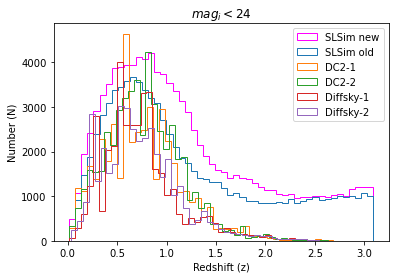

In [58]:
plt.hist(double_total[(double_total["mag_i"]<24)]["z"], bins=50, density=False, histtype="step",
    label="SLSim new", color="magenta", cumulative=False)
plt.hist(single_total[(single_total["mag_i"]<24)]["z"], bins=50, density=False, histtype="step",
            label="SLSim old", cumulative=False)
plt.hist(dc2_galaxies[(dc2_galaxies["mag_true_i_lsst"]<24)]["redshift"], bins=50, density=False, histtype="step",
            label="DC2-1", cumulative=False)
plt.hist(dc2_galaxies2[(dc2_galaxies2["mag_true_i_lsst"]<24)]["redshift"], bins=50, density=False, histtype="step",
            label="DC2-2", cumulative=False)
plt.hist(diffsky_galaxies[(diffsky_galaxies["mag_true_i_lsst"]<24)]["redshift"], bins=50, density=False, histtype="step",
            label="Diffsky-1", cumulative=False)
plt.hist(diffsky_galaxies2[(diffsky_galaxies2["mag_true_i_lsst"]<24)]["redshift"], bins=50, density=False, histtype="step",
            label="Diffsky-2", cumulative=False)
plt.xlabel("Redshift (z)")
plt.ylabel("Number (N)")
plt.legend(loc='upper right', fontsize=10)
plt.title(r"$mag_i < 24$")

Text(0.5, 1.0, '$2.5\\leq z < 3$')

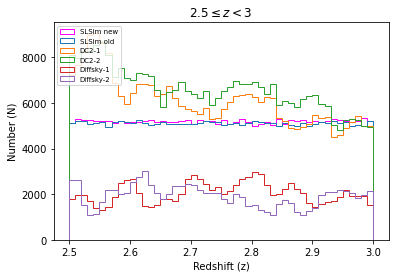

In [48]:
plt.hist(double_total[(double_total["mag_i"]<30) & (double_total["z"]>= 2.5) & (double_total["z"]< 3)]["z"], bins=50, density=False, histtype="step",
    label="SLSim new", color="magenta", cumulative=False)
plt.hist(single_total[(single_total["mag_i"]<30) & (single_total["z"]>=2.5) & (single_total["z"]<3)]["z"], bins=50, density=False, histtype="step",
            label="SLSim old", cumulative=False)
plt.hist(dc2_galaxies[(dc2_galaxies["mag_true_i_lsst"]<30) & (dc2_galaxies["redshift"]>=2.5) & (dc2_galaxies["redshift"]<3)]["redshift"], bins=50, density=False, histtype="step",
            label="DC2-1", cumulative=False)
plt.hist(dc2_galaxies2[(dc2_galaxies2["mag_true_i_lsst"]<30) & (dc2_galaxies2["redshift"]>=2.5) & (dc2_galaxies2["redshift"]<3)]["redshift"], bins=50, density=False, histtype="step",
            label="DC2-2", cumulative=False)
plt.hist(diffsky_galaxies[(diffsky_galaxies["mag_true_i_lsst"]<30) & (diffsky_galaxies["redshift"]>=2.5) & (diffsky_galaxies["redshift"]<3)]["redshift"], bins=50, density=False, histtype="step",
            label="Diffsky-1", cumulative=False)
plt.hist(diffsky_galaxies2[(diffsky_galaxies2["mag_true_i_lsst"]<30) & (diffsky_galaxies2["redshift"]>=2.5) & (diffsky_galaxies2["redshift"]<3)]["redshift"], bins=50, density=False, histtype="step",
            label="Diffsky-2", cumulative=False)
plt.xlabel("Redshift (z)")
plt.ylabel("Number (N)")
plt.legend(loc='upper left', fontsize=7)
plt.title(r"$2.5\leq z < 3$")

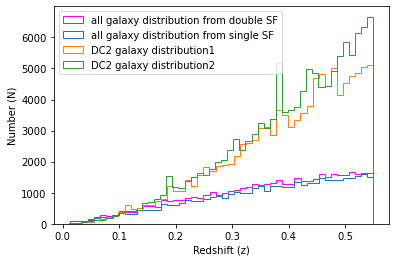

In [141]:
plt.hist(double_total[(double_total["mag_i"]>13.834526) & (double_total["z"]< 0.55)]["z"]
         , bins=50, density=False, histtype="step",
    label="all galaxy distribution from double SF", color="magenta", cumulative=False)
plt.hist(single_total[(single_total["mag_i"]>13.834526) & (single_total["z"]< 0.55)]["z"]
         , bins=50, density=False, histtype="step",
            label="all galaxy distribution from single SF", cumulative=False)
plt.hist(dc2_galaxies[dc2_galaxies["redshift"] < 0.55]["redshift"], bins=50, density=False, histtype="step",
            label="DC2 galaxy distribution1", cumulative=False)
plt.hist(dc2_galaxies2[dc2_galaxies2["redshift"] < 0.55]["redshift"], bins=50, density=False, histtype="step",
            label="DC2 galaxy distribution2", cumulative=False)
plt.xlabel("Redshift (z)")
plt.ylabel("Number (N)")
plt.legend(loc='upper left')